# Машинное обучение, ФКН ВШЭ

## Практическое задание (Бонус). Разложение ошибки на смещение и разброс

### Общая информация

Дата выдачи: 12.12.2023

Мягкий дедлайн: 23:59MSK 24.12.2023

Жесткий дедлайн: 23:59MSK 24.12.2023

### Оценивание и штрафы
Каждая из задач имеет определенную «стоимость» (указана в скобках около задачи). Максимально допустимая оценка за работу — 6 баллов.

Сдавать задание после указанного срока сдачи нельзя. При выставлении неполного балла за задание в связи с наличием ошибок на усмотрение проверяющего предусмотрена возможность исправить работу на указанных в ответном письме условиях.

Задание выполняется самостоятельно. «Похожие» решения считаются плагиатом и все задействованные студенты (в том числе те, у кого списали) не могут получить за него больше 0 баллов (подробнее о плагиате см. на странице курса). Если вы нашли решение какого-то из заданий (или его часть) в открытом источнике, необходимо указать ссылку на этот источник в отдельном блоке в конце вашей работы (скорее всего вы будете не единственным, кто это нашел, поэтому чтобы исключить подозрение в плагиате, необходима ссылка на источник).

Неэффективная реализация кода может негативно отразиться на оценке.

### Формат сдачи
Задания сдаются через систему anytask. Посылка должна содержать:
* Ноутбук homework-practice-07-Username.ipynb

Username — ваша фамилия и имя на латинице именно в таком порядке

### О задании

В этом задании вам предстоит воспользоваться возможностями бутстрапа для оценки смещения и разброса алгоритмов машинного обучения. Делать мы это будем на данных boston:

In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

In [2]:
# скопировал код из ошибки, которую выдает from sklearn.datasets import load_boston
import pandas as pd
import numpy as np

data_url = "http://lib.stat.cmu.edu/datasets/boston"
raw_df = pd.read_csv(data_url, sep="\s+", skiprows=22, header=None)
data = np.hstack([raw_df.values[::2, :], raw_df.values[1::2, :2]])
target = raw_df.values[1::2, 2]

In [3]:
X = data
y = target

In [4]:
X.shape, y.shape

((506, 13), (506,))

### Вычисление bias и variance с помощью бутстрапа
На лекции была выведено следующая формула, показывающая, как можно представить ошибку алгоритма регрессии в виде суммы трех компонент:
$$
L(\mu) =
    \mathbb{E}_{x, y}\bigl[\mathbb{E}_{X}\bigl[ (y - \mu(X)(x))^2 \bigr]\bigr] =
$$
$$
    \underbrace{\mathbb{E}_{x, y}\bigl[(y - \mathbb{E}[y|x] )^2\bigr]}_{\text{шум}} + \underbrace{\mathbb{E}_{x}\bigl[(\mathbb{E}_{X}[\mu(X)(x)] - \mathbb{E}[y|x] )^2\bigr]}_{\text{смещение}} +
    \underbrace{\mathbb{E}_{x}\bigl[\mathbb{E}_{X}\bigl[(\mu(X)(x) - \mathbb{E}_{X}[\mu(X)(x)] )^2\bigr]\bigr]}_{\text{разброс}},
$$
* $\mu(X)$ — алгоритм, обученный по выборке $X = \{(x_1, y_1), \dots (x_\ell, y_\ell)\}$;
* $\mu(X)(x)$ — ответ алгоритма, обученного по выборке $X$, на объекте $x$;
* $\mathbb{E}_{X}$ — мат. ожидание по всем возможным выборкам;
* $\mathbb{E}_{X}[\mu(X)(x)]$ — "средний" ответ алгоритма, обученного по всем возможным выборкам $X$, на объекте $x$.
    
С помощью этой формулы мы можем анализировать свойства алгоритма обучения модели $\mu$, если зададим вероятностную модель порождения пар $p(x, y)$.

В реальных задачах мы, конечно же, не знаем распределение на парах объект - правильный ответ. Однако у нас есть набор семплов из этого распределения (обучающую выборка), и мы можем использовать его, чтобы оценивать математические ожидания. Для оценки мат. ожиданий по выборкам мы будем пользоваться бутстрэпом - методом генерации "новых" выборок из одной с помощью выбора объектов с возвращением. Разберем несколько шагов на пути к оценке смещения и разброса.

#### Приближенное вычисление интегралов
На занятиях мы разбирали примеры аналитического вычисления смещения и разброса нескольких алгоритмов обучения. Для большинства моделей данных и алгоритмов обучения аналитически рассчитать математические ожидания в формулах не удастся. Однако мат. ожидания можно оценивать приближенно. Чтобы оценить математическое ожидание $\mathbb{E}_{\bar z} f(\bar z)$ функции от многомерной случайной величины $\bar z = (z_1, \dots, z_d)$, $\bar z \sim p(\bar z)$, можно сгенерировать выборку из распределения $p(\bar z)$ и усреднить значение функции на элементах этой выборки:
$$\mathbb{E}_{\bar z} f(z) = \int f(\bar z) p(\bar z) d \bar z \approx \frac 1 m \sum_{i=1}^m f(\bar z_i), \, \bar z_i \sim p(\bar z), i = 1, \dots, m.$$

Например, оценим $\mathbb{E}_z z^2,$ $z \sim \mathcal{N}(\mu=5, \sigma=3)$ (из теории вероятностей мы знаем, что
$\mathbb{E}_z z^2 = \sigma^2 + \mu^2 = 34$):

In [5]:
z = np.random.normal(loc=5, scale=3, size=1000)
(z**2).mean()

33.04423618190529

#### Оценивание $\mathbb{E}_{x, y}$
Оценить мат. ожидания по $x$ и по $x, y$, встречающиеся во всех трех компонентах разложения, несложно, потому что у нас есть выборка объектов из распределения данных $p(x, y)$:
$$ \mathbb{E}_{x} f(x) \approx \frac 1 N \sum_{i=1}^N f(x_i), \quad
\mathbb{E}_{x, y} f(x, y) \approx \frac 1 N \sum_{i=1}^N f(x_i, y_i),$$
где $N$ - число объектов в выборке, $\{(x_i, y_i)\}_{i=1}^N$ - сама выборка.

#### Оценивание $\mathbb{E}_X$ с помощью бутстрапа
Чтобы оценить мат. ожидание по $X$, нам понадобится выборка из выборок:
$$\mathbb{E}_X f(X) \approx \frac 1 s \sum_{j=1}^s f(X_j),$$
где $X_j$ - $j$-я выборка. Чтобы их получить, мы можем воспользоваться бутстрапом - методом генерации выборок на основе выбора объектов с возвращением. Чтобы составить одну выборку, будем $N$ раз выбирать индекс объекта $i \sim \text{Uniform}(1 \dots N)$ и добавлять $i$-ю пару (объект, целевая переменная) в выборку. В результате в каждой выборке могут появиться повторяющиеся объекты, а какие-то объекты могут вовсе не войти в некоторые выборки.

#### Итоговый алгоритм оценки смещения и разброса алгоритма $a$
1. Сгенерировать $s$ выборок $X_j$ методом бутстрапа.
1. На каждой выборке $X_j$ обучить алгоритм $a_j$.
1. Для каждой выборки $X_j$ определить множество объектов $T_j$, не вошедших в нее (out-of-bag). Вычислить предсказания алгоритма $a_j$ на объектах $T_j$.

Поскольку у нас есть только один ответ для каждого объекта, мы будем считать шум равным 0, а $\mathbb{E}[y|x]$ равным имеющемуся правильному ответу для объекта $x$.

Итоговые оценки:
* Смещение: для одного объекта - квадрат разности среднего предсказания и правильного ответа. Среднее предсказание берется только по тем алгоритмам $a_j$, для которых этот объект входил в out-of-bag выборку $T_j$. Для получения общего смещения выполнить усреденение смещений по объектам.
* Разброс: для одного объекта - выборочная дисперсия предсказаний алгоритмов $a_j$, для которых этот объект входил в out-of-bag выборку $T_j$. Для получения общего разброса выполнить усреденение разбросов по объектам.
* Ошибка $L$: усреднить квадраты разностей предсказания и правильного ответа по всем выполненным предсказаниям для всех объектов.

В результате должно получиться, что ошибка приблизительно равна сумме смещения и разброса!

Алгоритм также вкратце описан по [ссылке](https://web.engr.oregonstate.edu/~tgd/classes/534/slides/part9.pdf) (слайды 19-21).

__1. (1.5 балла)__

Реализуйте описанный алгоритм. Обратите внимание, что если объект не вошел ни в одну из out-of-bag выборок, учитывать его в вычислении итоговых величин не нужно. Как обычно, разрешается использовать только один цикл - по выборкам (от 0 до num_runs-1).

In [6]:
def compute_biase_variance(regressor, X, y, num_runs=1000):
    """
    :param regressor: sklearn estimator with fit(...) and predict(...) method
    :param X: numpy-array representing training set ob objects, shape [n_obj, n_feat]
    :param y: numpy-array representing target for training objects, shape [n_obj]
    :param num_runs: int, number of samples (s in the description of the algorithm)

    :returns: bias (float), variance (float), error (float)
    each value is computed using bootstrap
    """
    sum = np.zeros(X.shape[0])
    sq_preds = np.zeros(X.shape[0])
    out_of_bag_cnt = np.zeros(X.shape[0])
    err = np.zeros(X.shape[0])
    for s in range(num_runs):
      indices = np.random.choice(X.shape[0], X.shape[0], True)
      unique_indices = np.unique(indices)
      out_of_bag_indices = np.setdiff1d(np.arange(X.shape[0]), unique_indices)
      regressor.fit(X[indices], y[indices])
      y_pred = regressor.predict(X)
      sum[out_of_bag_indices] += y_pred[out_of_bag_indices]
      out_of_bag_cnt[out_of_bag_indices] += 1
      sq_preds[out_of_bag_indices] += y_pred[out_of_bag_indices] ** 2
      err[out_of_bag_indices] += (y_pred[out_of_bag_indices] - y[out_of_bag_indices]) ** 2

    avg_pred = sum / out_of_bag_cnt
    bias = np.mean((avg_pred - y) ** 2)
    avg_sq_preds = sq_preds / out_of_bag_cnt
    variance = np.mean(avg_sq_preds - avg_pred ** 2)
    error = np.mean(err / out_of_bag_cnt)
    return bias, variance, error

__2. (0 баллов)__

Оцените смещение, разброс и ошибку для трех алгоритмов с гиперпараметрами по умолчанию: линейная регрессия, решающее дерево, случайный лес.

In [7]:
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor

bias, variance, error = compute_biase_variance(LinearRegression(), X, y)
print("linear regression bias variance and error:")
print("bias: " + str(bias))
print("variance: " + str(variance))
print("error: " + str(error))
print("===============================")

bias, variance, error = compute_biase_variance(DecisionTreeRegressor(), X, y)
print("decision tree bias variance and error:")
print("bias: " + str(bias))
print("variance: " + str(variance))
print("error: " + str(error))
print("===============================")

bias, variance, error = compute_biase_variance(RandomForestRegressor(), X, y)
print("RF bias variance and error:")
print("bias: " + str(bias))
print("variance: " + str(variance))
print("error: " + str(error))

linear regression bias variance and error:
bias: 23.715204644548127
variance: 0.9421451169719184
error: 24.657349761520056
decision tree bias variance and error:
bias: 10.280940399860295
variance: 13.08162815736646
error: 23.36256855722677
RF bias variance and error:
bias: 10.566874618189276
variance: 2.2207613793057166
error: 12.787635997494979


__3. (0.5 баллов)__
Проанализируйте полученный результат. Согласуются ли полученные результаты с теми, что мы обсуждали на занятиях (с комментарием)?

__Your answer here:__ На лекции обсуждалось, что у линейных моделей будет довольно высокий bias (так как обычно наши данные неочень хорошо приближаются линейно) и низкий variance (так как модели несильно отклоняются от средней, это было видно на рисунке с лекции 11). У решающих деревьев bias небольшой и variance уже значительно больше чем у линейных моделей. Это согласуется с полученными мною результатами. Random Forest имеет тот же bias как и решающее дерево (ну у меня он чуть-чуть отличается, но не значительно) и variance в несколько раз меньше чем у решающего дерева, что тоже сходится с лекцией 11. Ошибка в RF в 2 раза меньше чем у решающего дерева, что сходится со знаниями полученными с лекции 10 (там говорилось, что у композиции ошибка в несколько раз меньше)

__4. (0.5 баллов)__
Постройте бэггинг над всеми тремя моделями (линейная регрессия, решающее дерево, случайный лес). Вспомните обсуждение с лекции о том, во сколько раз в теории бэггинг уменьшает разброс базового алгоритма. Выполняется ли это в ваших экспериментах? Если нет, поясните, почему.

__Your answer here:__ В случае бэггинга над решающими деревьями это выполняется. В случае линейной модели нет, но там и изначльно variance был небольшим, ну и чтобы "хорошо" уменьшить variance нам нужно чтобы модели не были скореллированы между собой и в случае линейных моделей видимо это трудновыполнимо. Бэггинг поверх RF вообще профита никакого почти не дал. Ну и по-моему это довольно странная штука, так как random forest это тоже своего рода бэггинг (только уже над решающими деревьями) и бэггинг над бэггингом - звучит неочень.

In [8]:
from sklearn.ensemble import BaggingRegressor

bias, variance, error = compute_biase_variance(BaggingRegressor(LinearRegression()), X, y)
print("linear regression with bagging:")
print("bias: " + str(bias))
print("variance: " + str(variance))
print("error: " + str(error))
print("===============================")

bias, variance, error = compute_biase_variance(BaggingRegressor(DecisionTreeRegressor()), X, y)
print("decision tree with bagging:")
print("bias: " + str(bias))
print("variance: " + str(variance))
print("error: " + str(error))
print("===============================")

# я ограничил num_runs, а то приходится ждать очень долго, чтобы оно посчиталось
bias, variance, error = compute_biase_variance(BaggingRegressor(RandomForestRegressor()), X, y, num_runs=50)
print("RF with bagging:")
print("bias: " + str(bias))
print("variance: " + str(variance))
print("error: " + str(error))

linear regression with bagging:
bias: 23.821857688186622
variance: 1.0768944693100233
error: 24.898752157496656
decision tree with bagging:
bias: 10.815463812989552
variance: 3.4922511630836044
error: 14.307714976073106
RF with bagging:
bias: 11.226204520077452
variance: 1.460610116893684
error: 12.68681463697114


### Визуализация предсказаний базовых алгоритмов бэггинга

В материалах лекций можно найти изображение, похожее на мишень - визуализация алгоритмов с разным смещением и разным разбросом. В центре "мишени" - правильный ответ, а "попадания" - предсказания алгоритмов, обученных по разным выборкам. Построим похожее изображение на наших данных для трех алгоритмов. Наши "мишени" будут одномерными, потому что мы решаем задачу одномерной регрессии.

__5. (1.5 балла)__

Реализуйте функцию plot_predictions. Она должна выполнять следующие действия:
1. Случайно выбрать num_test_objects пар объект-целевая переменная из выборки X, y. Получится две выборки: маленькая X_test, y_test (выбранные тестовые объекты) и X_train, y_train (остальные объекты).
1. Сгенерировать num_runs выборок методом бутстарапа из X_train, y_train. На каждой выборке обучить алгоритм regressor и сделать предсказания для X_test.
1. Нарисовать scatter-график. По оси абсцисс - объекты тестовой выборки (номера от 0 до num_test_objects-1), по оси ординат - предсказания. В итоге получится num_test_objects столбиков с точками. Для каждого тестового объекта надо отметить одним цветом все предсказания для него, а также черным цветом отметить правильный ответ.
1. Подпишите оси и название графика (аргумент title).

In [10]:
def plot_predictions(regressor, X, y, axes, ind, num_runs=100, num_test_objects=10, title=""):
    """
    plot graphics described above
    """
    test_indices = np.random.choice(X.shape[0], num_test_objects, False)
    X_test = X[test_indices]
    y_test = y[test_indices]
    train_indices = np.setdiff1d(np.arange(X.shape[0]), test_indices)
    X_train = X[train_indices]
    y_train = y[train_indices]
    preds = np.empty((num_test_objects, num_runs))
    for s in range(num_runs):
      bootstrap_indices = np.random.choice(X_train.shape[0], X_train.shape[0], True)
      regressor.fit(X_train[bootstrap_indices], y_train[bootstrap_indices])
      y_test_pred = regressor.predict(X_test)
      preds[:, s] = y_test_pred

    axes[ind].set_title(title)
    axes[ind].set_xticks(np.arange(num_test_objects))
    axes[ind].set_xlabel("Test object number")
    axes[ind].set_ylabel("Predictions")
    for test_obj_ind in range(num_test_objects):
      axes[ind].scatter(np.full(preds[test_obj_ind].shape[0], test_obj_ind), preds[test_obj_ind])
    axes[ind].scatter(np.arange(num_test_objects), y_test, color='black')

__6. (0 баллов)__

Нарисуйте графики для линейной регрессии, решающего дерева и случайного леса. Нарисуйте три графика в строчку (это можно сделать с помощью plt.subplot) с одинаковой осью ординат (это важно для понимания масштаба разброса у разных алгоритмов):

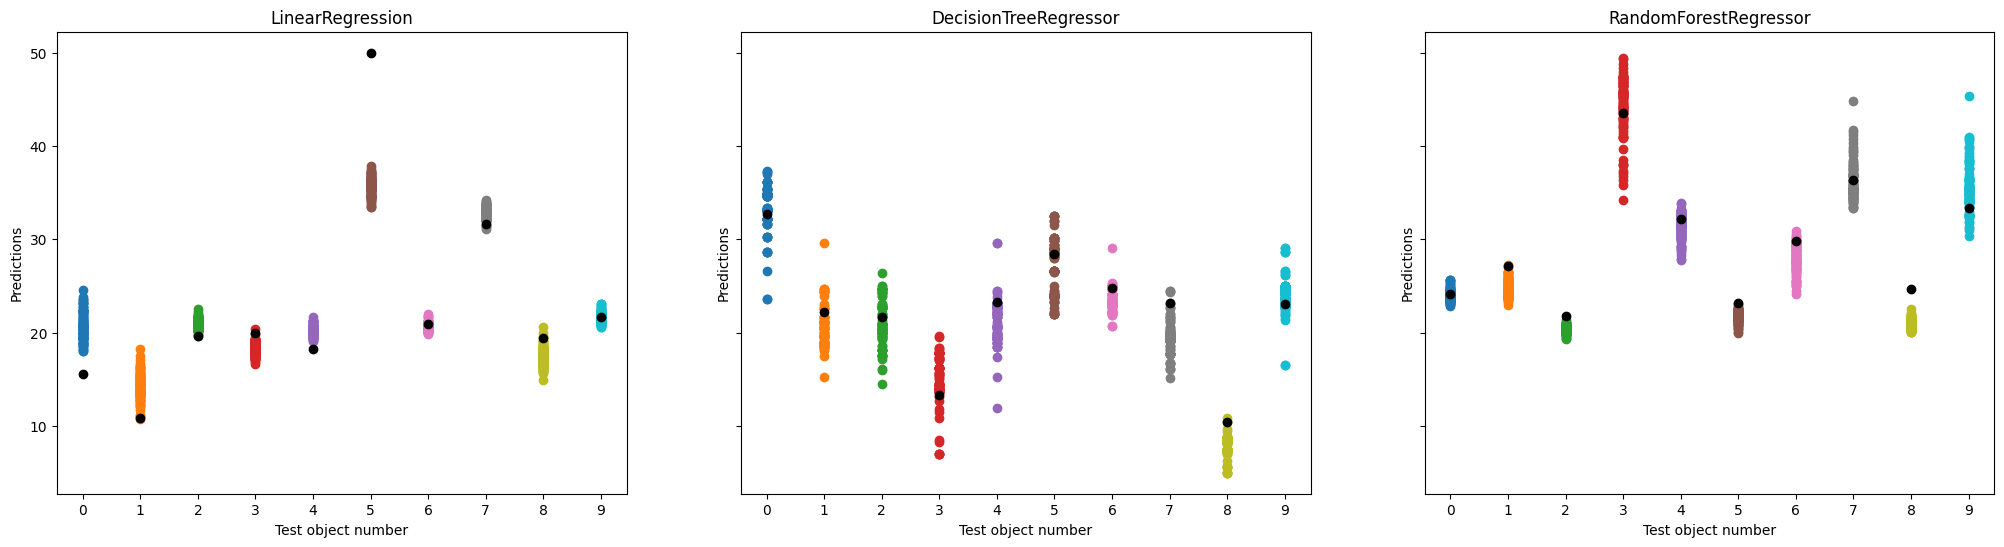

In [11]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(25, 6), sharey=True)

plot_predictions(LinearRegression(), X, y, axes=axes, ind=0, title="LinearRegression")
plot_predictions(DecisionTreeRegressor(), X, y, axes=axes, ind=1, title="DecisionTreeRegressor")
plot_predictions(RandomForestRegressor(), X, y, axes=axes, ind=2, title="RandomForestRegressor")

__7. (0.5 баллов)__

Для каждого графика прокомментируйте, как он характеризует смещение и разброс соответствующего алгоритма.

__Your answer here:__ В случае линейной регресии видно, что наши предсказания образуют почти что прямую линию, что говорит о крайне низком variance. При этом правильный ответ на объект лежит иногда довольно таки далеко от этой прямой, поэтому bias довольно высокий.

В случае решающих деревьев видно, что bias поменьше, так как черная точка попадает в отрезок между самой высокой голубой точкой и самой низкой. Также невооруженным глазом видно, что variance здесь больше, чем у линрега, так как точки не образуют прямую линию, некоторые из них отделены друг от друга, причем некоторые довольно далеко "оторвались" от основной массы голубых точек.

В случае RF видно, что RF "исправляет" высокий разброс, который есть у обычных решающих деревьев (голубые точки кучнее располагаются), но он все равно присутствует. Кроме того, сохраняется низкий bias (примерно такой же как и у решающих деревьев).

### Изменение bias и variance при изменении гиперпараметров

__8. (0 баллов)__

Постройте графики зависимости смещения и разброса от гиперпараметров решающего дерева max_depth (от 1 до 10) и max_features (от 1 до X.shape[1]):

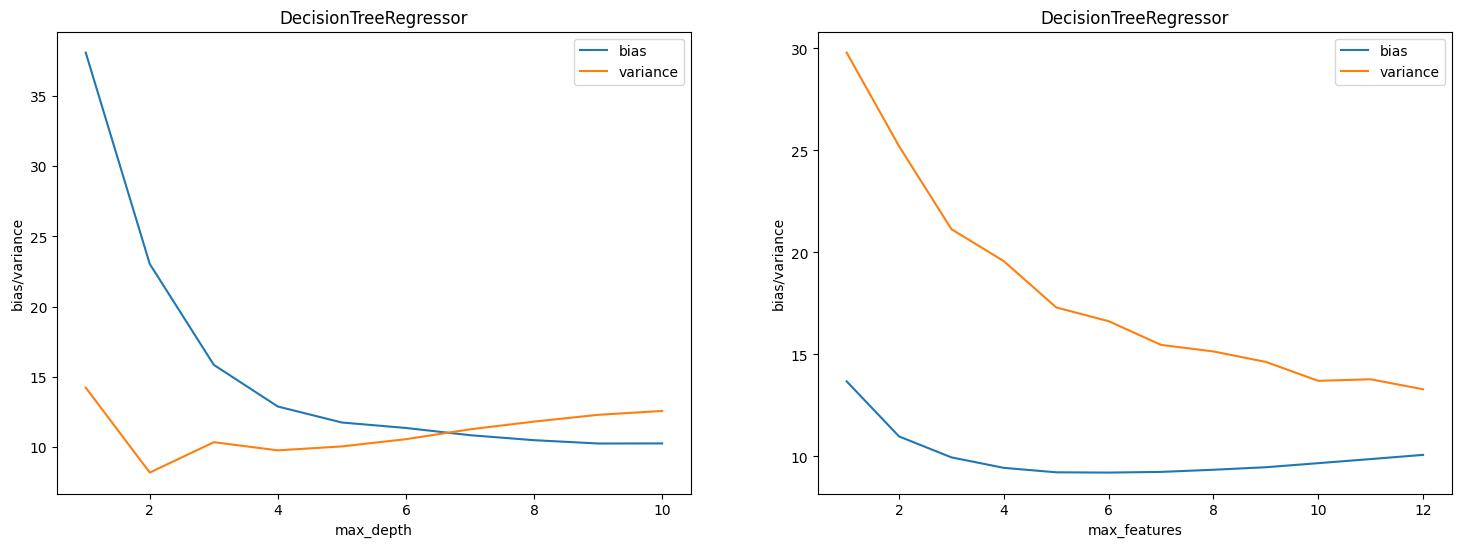

In [13]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(18, 6))

biases_max_depth = []
variances_max_depth = []
for max_depth in range(1, 11):
  regressor = DecisionTreeRegressor(max_depth=max_depth)
  bias, variance, _ = compute_biase_variance(regressor, X, y)
  biases_max_depth.append(bias)
  variances_max_depth.append(variance)
axes[0].set_title("DecisionTreeRegressor")
axes[0].set_xlabel("max_depth")
axes[0].set_ylabel("bias/variance")
axes[0].plot(np.arange(1, 11), biases_max_depth)
axes[0].plot(np.arange(1, 11), variances_max_depth)
axes[0].legend(labels=['bias', 'variance'])

biases_max_features = []
variances_max_features = []
for max_features in range(1, X.shape[1]):
  regressor = DecisionTreeRegressor(max_features=max_features)
  bias, variance, _ = compute_biase_variance(regressor, X, y)
  biases_max_features.append(bias)
  variances_max_features.append(variance)
axes[1].set_title("DecisionTreeRegressor")
axes[1].set_xlabel("max_features")
axes[1].set_ylabel("bias/variance")
axes[1].plot(np.arange(1, X.shape[1]), biases_max_features)
axes[1].plot(np.arange(1, X.shape[1]), variances_max_features)
axes[1].legend(labels=['bias', 'variance'])

__9. (0 баллов)__

Постройте графики зависимости смещения и разброса от n_estimators (по сетке 2**np.arange(1, 10)) для случайного леса и градиентного бустинга:

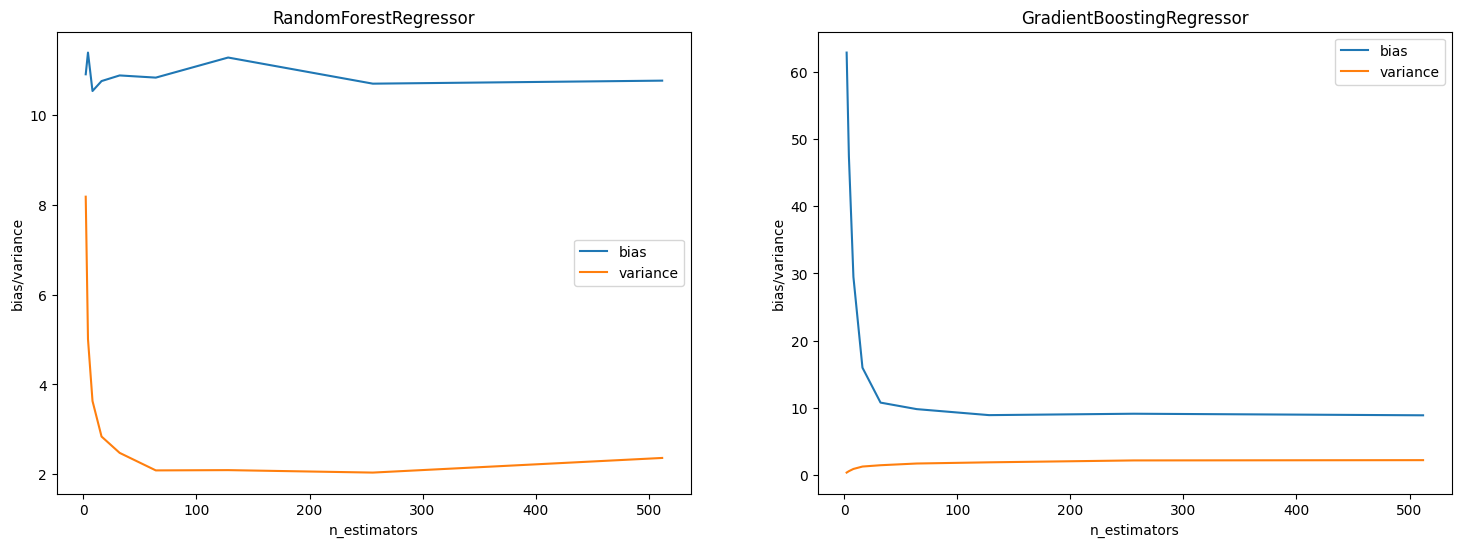

In [14]:
from sklearn.ensemble import GradientBoostingRegressor

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(18, 6))

biases_rf = []
variances_rf = []
for n_estimators in 2 ** np.arange(1, 10):
  regressor = RandomForestRegressor(n_estimators=n_estimators)
  bias, variance, _ = compute_biase_variance(regressor, X, y, num_runs=50)
  biases_rf.append(bias)
  variances_rf.append(variance)
axes[0].set_title("RandomForestRegressor")
axes[0].set_xlabel("n_estimators")
axes[0].set_ylabel("bias/variance")
axes[0].plot(2 ** np.arange(1, 10), biases_rf)
axes[0].plot(2 ** np.arange(1, 10), variances_rf)
axes[0].legend(labels=['bias', 'variance'])

biases_boosting = []
variances_boosting = []
for n_estimators in 2 ** np.arange(1, 10):
  regressor = GradientBoostingRegressor(n_estimators=n_estimators)
  bias, variance, _ = compute_biase_variance(regressor, X, y, num_runs=50)
  biases_boosting.append(bias)
  variances_boosting.append(variance)
axes[1].set_title("GradientBoostingRegressor")
axes[1].set_xlabel("n_estimators")
axes[1].set_ylabel("bias/variance")
axes[1].plot(2 ** np.arange(1, 10), biases_boosting)
axes[1].plot(2 ** np.arange(1, 10), variances_boosting)
axes[1].legend(labels=['bias', 'variance'])

__10. (1.5 балла)__

Прокомментируйте графики (всего 4 графика): почему они имеют такой вид.

__Your answer here:__ DecisionTreeRegressor - на лекции обсуждалось, что чем более глубокое дерево, тем меньше bias и тем больше variance (то есть с увеличением max_depth мы переобучаемся).

Ну по второму графику для DecisionTreeRegressor можем сделать вывод, что ограничивая max_features мы можем избежать переобучения (примерно с max_features == 7 bias потихоньку начал расти). Но variance при этом стабильно снижается при росте max_features.

Если внимательно приглядется, то bias на графике RandomForestRegressor примерно такой же, как и у обычного решающего дерева (примерно 10). Ну и этом сходится с информацией с лекций (что bias остается таким же). variance довольно резко падает, и затем остается довольно низким (под конец начинает чутка расти). Как уже было сказано выше в этой дз (ну и доказано output-ом кода), RF имеет разброс в несколько раз меньший, чем у обычных решающих деревьев.

У последнего графика (графика для бустинга) видим, что в начале bias крайне высокий, но затем он выходит на уровень bias'a для RF. variance же, в отличие от RF, постоянно "на дне" и с ним всегда всё ок.

__11. Бонус (0.1 балла)__


Прикрепите фотографию того, как вы начали эту зиму ❄️

__Your answer here:__